In [1]:
import pathlib
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches
import mplstereonet
import skimage.exposure
import harmonica as hm
import verde as vd

import micromag as mg

import time
import os

# Read QDM data

First, we create a read the observation points.

In [2]:
nc_file = "NRM18.mat"
data_dir = pathlib.Path("")/"real-data"
data = mg.load_qdm(data_dir / nc_file)

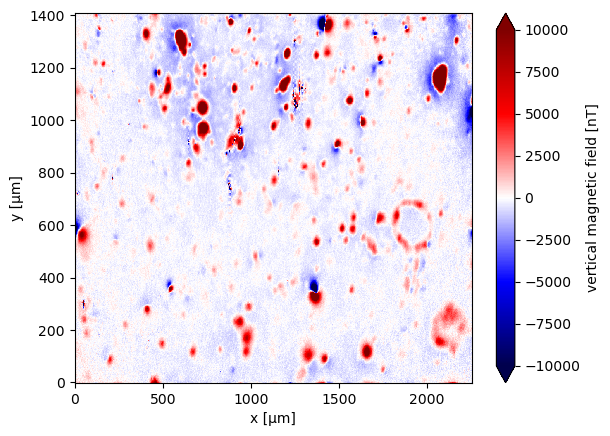

In [3]:
data.bz.plot.pcolormesh(cmap="seismic", vmax=10000, vmin=-10000)

In [4]:
# copy data sets
data_copy = data.copy(deep=True)
data_copy2 = data_copy.copy(deep=True)

x_, y_ = np.meshgrid(data.x.values, data.y.values)
coordinates = ([x_, y_ , data.z.values])

# Anomaly detection

First part of our method is an automatic way to detect and separate the signal of each dipole in the data. This is done in the following steps:

1. Upward continue the data to suppress high frequency noise
2. Calculate the total gradient amplitude (TGA) to concentrate the anomalies on top of the sources
3. Contrast stretch the TGA to highlight weaker sources
4. Run the Laplacian of Gaussian (LoG) method for blog detection to find the anomalies

## 1. Upward continue the data to suppress the high-frequency noise

In this step, we want to upward continue as little as possible to make sure we retain most of the signal.

In [5]:
height_difference = 5

# Have to assign the same points as the data because the Harmonica
# transforms give slightly different coordinates due to round-off.
# This is a bug and is being worked on.
data_up = (
    hm.upward_continuation(data.bz, height_difference)
    .assign_attrs(data.bz.attrs)
    .to_dataset(name="bz")
    .assign_coords(x=data.x, y=data.y)
    .assign_coords(z=data.z + height_difference)
)
data_up

/home/gelson/anaconda3/envs/micromag-euler-dipole/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.Dataset> Size: 9MB
Dimensions:  (y: 600, x: 960)
Coordinates:
  * x        (x) float64 8kB 0.0 2.35 4.7 7.05 ... 2.249e+03 2.251e+03 2.254e+03
  * y        (y) float64 5kB 0.0 2.35 4.7 7.05 ... 1.403e+03 1.405e+03 1.408e+03
    z        (y, x) float64 5MB 10.0 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz       (y, x) float64 5MB 222.3 277.0 300.6 315.3 ... 79.43 111.8 148.3

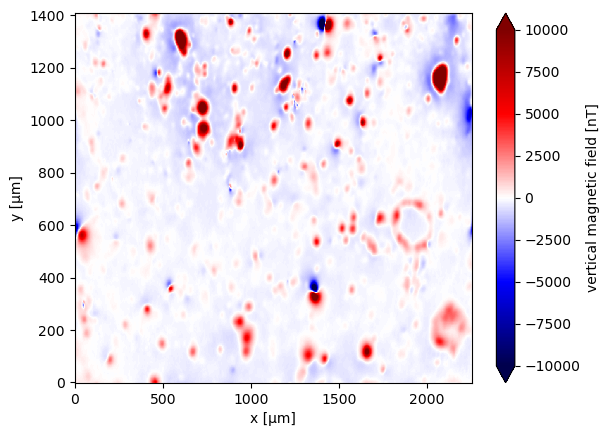

In [6]:
data_up.bz.plot.pcolormesh(cmap="seismic", vmax=10000, vmin=-10000)

## 2. Calculate the TGA

We do this with finite difference derivatives to avoid amplifying noise.

In [7]:
data_up = data_up.assign(mg.data_gradients(data_up.bz))
data_up

/home/gelson/anaconda3/envs/micromag-euler-dipole/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/gelson/anaconda3/envs/micromag-euler-dipole/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.Dataset> Size: 28MB
Dimensions:  (y: 600, x: 960)
Coordinates:
  * x        (x) float64 8kB 0.0 2.35 4.7 7.05 ... 2.249e+03 2.251e+03 2.254e+03
  * y        (y) float64 5kB 0.0 2.35 4.7 7.05 ... 1.403e+03 1.405e+03 1.408e+03
    z        (y, x) float64 5MB 10.0 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz       (y, x) float64 5MB 222.3 277.0 300.6 315.3 ... 79.43 111.8 148.3
    tga      (y, x) float64 5MB 41.69 53.86 42.11 40.74 ... 10.91 17.49 19.32
    x_deriv  (y, x) float64 5MB 23.27 16.67 8.148 4.367 ... 10.3 14.65 15.52
    y_deriv  (y, x) float64 5MB 1.969 4.45 7.309 9.855 ... -3.527 0.6842 6.196
    z_deriv  (y, x) float64 5MB -34.53 -51.02 -40.67 ... 0.8016 -9.524 -9.686

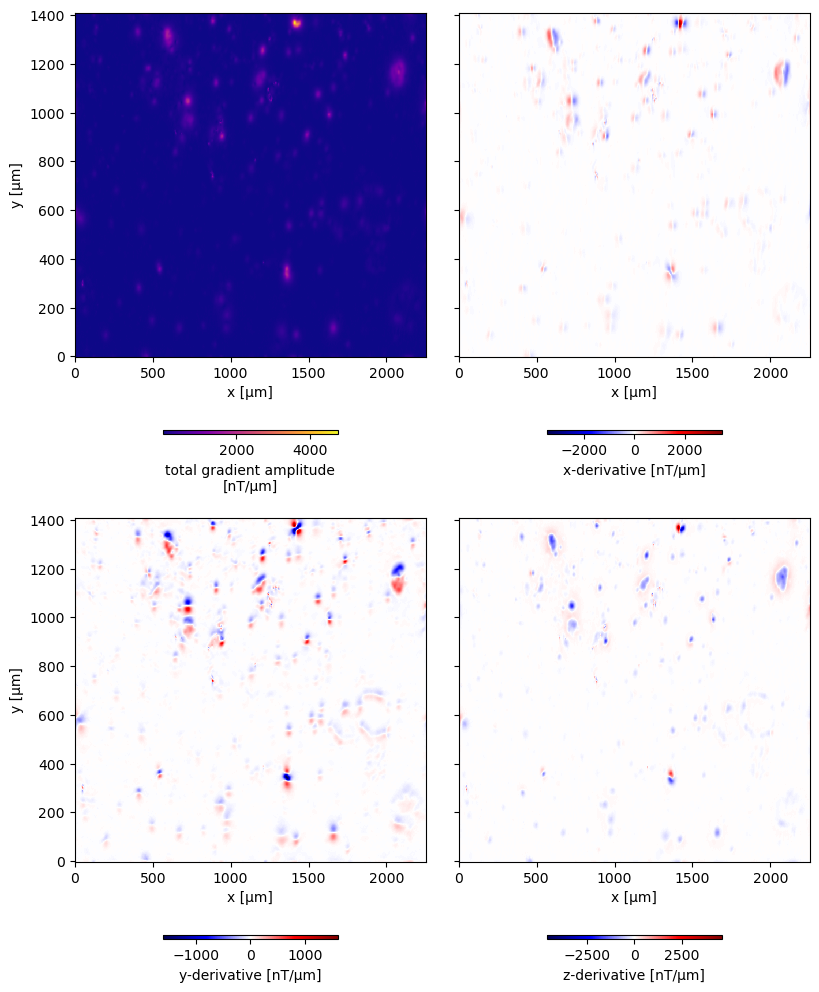

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(8, 10), sharey="row")
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.15, shrink=0.5)
for field, ax in zip(["tga", "x_deriv", "y_deriv", "z_deriv"], axes.ravel()):
    if field == "tga":
        cmap = "plasma"
    else:
        cmap="seismic"
    data_up[field].plot.pcolormesh(ax=ax, cmap=cmap, cbar_kwargs=cbar_kwargs)
for ax in axes.ravel():
    ax.set_aspect("auto")
    
axes[0,1].set_ylabel(None)
axes[1,1].set_ylabel(None)
plt.tight_layout(pad=0, h_pad=0, w_pad=2)

## 3. Stretch the contrast

Now we need to stretch the contrast of the TGA to make the anomalies easier to detect.

In [9]:
stretched = skimage.exposure.rescale_intensity(
    data_up.tga, 
    in_range=tuple(np.percentile(data_up.tga, (1, 99))),
)
data_up = data_up.assign(tga_stretched=xr.DataArray(stretched, coords=data_up.coords))

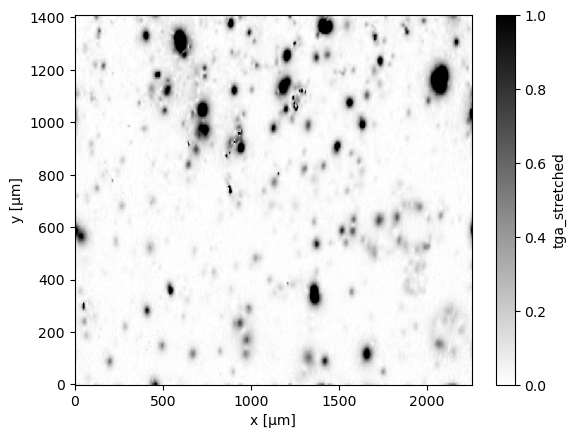

In [10]:
data_up.tga_stretched.plot.pcolormesh(cmap="gray_r")

## 4. Blob detection

To detect the bounding boxes of each anomaly, we use the LoG method in scikit-image. The code below calls it with some conveniences, like passing the range of anomaly sizes in physical units (µm) instead of number of pixels. It returns the bounding box of each anomaly (x_min, x_max, y_min, y_max) also in physical units.

In [11]:
start_detection_time = time.perf_counter()

windows = mg.detect_anomalies(
    data_up.tga_stretched, 
    size_range=[20, 100],
    size_increment=1.0,
    threshold=0.025,
    overlap=1.0,
    exclude_border=50,
    nsizes=20,
)

end_detection_time = time.perf_counter()

In [12]:
detection_time = end_detection_time-start_detection_time

print(f'{np.shape(windows)[0]} potential sources detected within {round(detection_time, 4)} seconds', )

272 potential sources detected within 2.0549 seconds


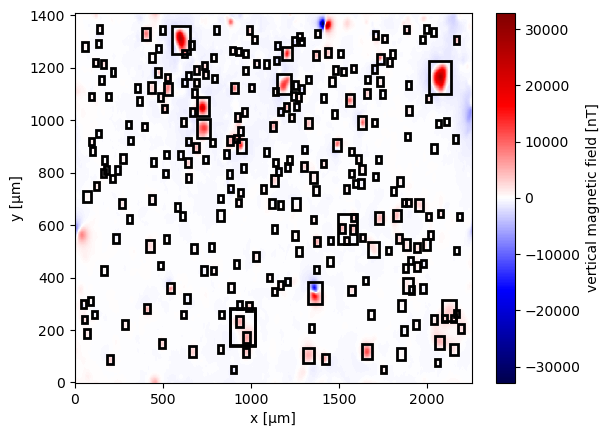

In [13]:
ax = plt.subplot(111)
data_up.bz.plot.pcolormesh(ax=ax, cmap="seismic")
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)   

Now that we know the bounding box of each anomaly, we can run the Euler deconvolution and moment inversion for each anomaly separately.

# Euler Deconvolution and Inversion (Standard method)

Run the Euler Deconvolution and the inversion on each window.

In [14]:
start_inversion_time = time.perf_counter()

positions = []
estimated_dipole_moments = []
estimated_stds = []
calculated_r2 = []
calculated_SNR = []
windows_filtered = []
base_levels = []
for window in windows:
    anomaly = data_up.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )
    
#     anomaly = data.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    data_minus_background = anomaly.bz.values - base_level
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}

    moment, covariance, r2, SNR = mg.dipole_moment_inversion(
        anomaly.data_minus_background, position,
    )
    
    # Filter out solutions that don't meet quality criteria
    bad_euler = False # position[2] > 0
    poor_fit = False
    
#    bad_euler = position[2] > 0
#     poor_fit = r2 < 0.85
    if bad_euler or poor_fit:
        continue
#     print("R²: %s and SNR: %s"%(r2,SNR))  
    positions.append(position)  
    estimated_dipole_moments.append(moment)
    estimated_stds.append(mg.covariance_to_angle_std(moment, covariance))
    calculated_r2.append(r2)
    calculated_SNR.append(SNR)
    windows_filtered.append(window)
    base_levels.append(base_level)
positions = np.transpose(positions)


end_inversion_time = time.perf_counter()

In [15]:
inversion_time = end_inversion_time-start_inversion_time
print(f"{positions.shape[1]} euler positions and dipole moments estimated within {round(inversion_time, 4)} seconds", )

272 euler positions and dipole moments estimated within 2.2823 seconds


# Iterative Euler deconvolution

In [16]:
import scipy as sp
import numba
import choclo
# @numba.jit(nopython=True, parallel=True)
def goal_function(parameter, obs_data, coordinates, amplitude, x_0, y_0, z_0):
    bz = mg.dipole_bz(coordinates, 
                      ([parameter[0]*x_0], [parameter[1]*y_0], [parameter[2]*z_0]),
                     np.array([parameter[3], parameter[4], parameter[5]])*amplitude
                     )
                   
    
    Res = np.linalg.norm(obs_data-bz.ravel())
    # print(Res)
    return(Res)

In [17]:
x_, y_ = np.meshgrid(data.x.values, data.y.values)
coordinates = ([x_, y_ , data.z.values])

In [18]:
import warnings
import rich.progress

warnings.filterwarnings("ignore")

start_itr_euler_time = time.perf_counter()


x_concat = []
y_concat = []
z_concat = []
bz_concat = []
xc_concat = []
yc_concat = []
zc_concat = []
z_deriv_concat = []

estimated_dipole_moments_itr_euler = []

# fitting parameters
calculated_r2_itr_euler = []
calculated_SNR_itr_euler = []

data_copy = data.copy(deep=True)
data_up_copy = data_up.copy(deep=True)

base_levels_itr_euler = []
#################################
for window in rich.progress.track(np.array(windows), total = len(np.array(windows))):
    anomaly = data_up_copy.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )

    base_levels_itr_euler.append(base_level)
    data_minus_background = anomaly.bz.values - base_level 
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}

    
    moment, covariance, r2, SNR = mg.dipole_moment_inversion(anomaly.data_minus_background, position)

    ## SCIPY MINIMIZATION

    anomaly_table=vd.grid_to_table(anomaly)
    amplitude = np.linalg.norm(moment)
    args=(data_minus_background.ravel(), 
         ( anomaly_table.x.values,
           anomaly_table.y.values, 
           anomaly.z.values.ravel()),
          amplitude, position[0], position[1], position[2])
    
    minimization=sp.optimize.minimize(goal_function, (1, 1, 1,
                                                      moment[0]/amplitude,
                                                      moment[1]/amplitude,
                                                      moment[2]/amplitude),
                                      
                                      args=args,
                                      
                                        method='Nelder-Mead', options=dict(fatol=1.0e-8))
    
    # print(minimization.x[0])
    if minimization.success:
        
        moment = np.array([minimization['x'][3], minimization['x'][4], minimization['x'][5]])*amplitude
        position = np.array([minimization['x'][0]*position[0], 
                             minimization['x'][1]*position[1],
                             minimization['x'][2]*position[2]])
        xxx, yyy = np.meshgrid(anomaly.x.values, anomaly.y.values)
        zzz = anomaly.z.values.ravel()
        pred = mg.dipole_bz([xxx, yyy, zzz], 
                  position,
                  moment
                 )
        
        residuals = data_minus_background.ravel() - pred.ravel()
        residuals_sum_sq = np.sum(residuals**2)
        r2 = 1 - residuals_sum_sq / np.linalg.norm(data_minus_background.ravel() - np.mean(data_minus_background.ravel())) ** 2


    estimated_dipole_moments_itr_euler.append(moment)
    
    #########
    
    discard = mg.dipole_bz(coordinates, position, moment)

    data_copy.bz.values -= discard
    
#     print(discard.max())
    data_up_copy = (
                hm.upward_continuation(data_copy.bz, height_difference)
                .assign_attrs(data_copy.bz.attrs)
                .to_dataset(name="bz")
                .assign_coords(x=data_copy.x, y=data_copy.y)
                .assign_coords(z=data_copy.z + height_difference)
                   )
    
    
    data_up_copy = data_up_copy.assign(mg.data_gradients(data_up_copy.bz))
    
    
    ########
    # Filter out solutions that don't meet quality criteria
    bad_euler = False #position[2] > 0.0
    poor_fit =  False # r2 < 0.85  

    if bad_euler or poor_fit:
        continue
#     print("R²: %s and SNR: %s | %s"%(r2,SNR,position[2]))  
    xx, yy = np.meshgrid(anomaly.x.values, anomaly.y.values)
    x_concat = np.append(x_concat, xx)
    y_concat = np.append(y_concat, yy)    
    z_concat = np.append(z_concat, anomaly.z.values)
    bz_concat = np.append(bz_concat, anomaly.bz.values)
    z_deriv_concat = np.append(z_deriv_concat, anomaly.z_deriv.values)
    xc_concat = np.append(xc_concat, position[0])
    yc_concat = np.append(yc_concat, position[1])
    zc_concat = np.append(zc_concat, position[2])
    calculated_r2_itr_euler = np.append(calculated_r2_itr_euler, r2)
    calculated_SNR_itr_euler = np.append(calculated_SNR_itr_euler, SNR)


end_itr_euler_time = time.perf_counter()
warnings.resetwarnings()

Output()

In [19]:
itr_euler_time = end_itr_euler_time-start_itr_euler_time
print(f"Time for the iterative Euler solution and dipole moment estimation: {round(itr_euler_time, 4)} seconds", )

Time for the iterative Euler solution and dipole moment estimation: 80.0855 seconds


In [20]:
df = pd.DataFrame({'x':x_concat,
                   'y':y_concat,
                   'z':z_concat,
                  'bz':bz_concat,
                 'z_deriv':z_deriv_concat})

df.head()

x        y     z           bz    z_deriv
0  2013.95  1102.15  10.0  -411.210197   9.782306
1  2016.30  1102.15  10.0  -568.600486  33.663807
2  2018.65  1102.15  10.0  -749.758415  61.681472
3  2021.00  1102.15  10.0  -929.866884  73.389378
4  2023.35  1102.15  10.0 -1111.496255  86.019565

In [21]:
positions_itr = np.array([xc_concat, yc_concat, zc_concat])

In [22]:
# indexes = np.where(~np.array(euler_r2_itr_cond))[0]
# indexes
# euler_r2_itr_cond

Output()

Output()

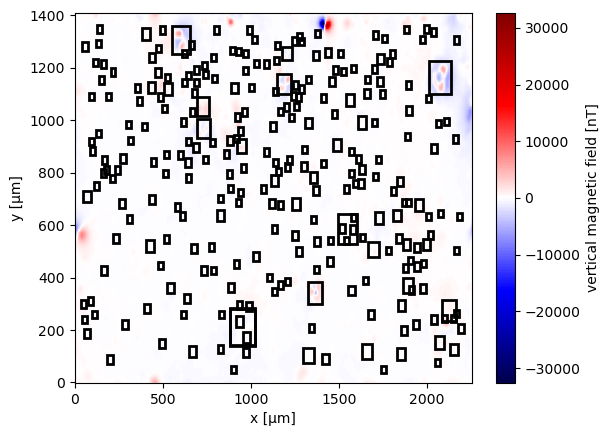

In [23]:
## EULER ENHANCEMENT SECOND STEP
warnings.filterwarnings("ignore")
data_copy = data.copy(deep=True)
euler_r2_itr_cond = calculated_r2_itr_euler>=0.999

zc_concat_temp = list()
xc_concat_temp = list()
yc_concat_temp = list()

estimated_dipole_moments_itr_euler_temp = list()

indexes = np.where(np.array(euler_r2_itr_cond))[0]
# SOURCES WITH R2 >= 0.99 ARE NOT ENHANCED, WE CALCULATE THEIR ANOMALY AND REMOVE THEM FROM THE DATA SET
# for index, window in enumerate(rich.progress.track(np.array(windows)[euler_r2_itr_cond], total=len(np.array(windows)[euler_r2_itr_cond]))):
for index in rich.progress.track(indexes, total=len(indexes)):
    window = windows[index]
    position = positions_itr[:, index]
    estimated_dipole_moments_itr_euler_temp.append(estimated_dipole_moments_itr_euler[index])
    xc_concat_temp = np.append(xc_concat_temp, position[0])
    yc_concat_temp = np.append(yc_concat_temp, position[1])
    zc_concat_temp = np.append(zc_concat_temp, position[2])  

    
# remove all signals 
position_temp = np.array([xc_concat_temp, yc_concat_temp, zc_concat_temp])
discard = mg.dipole_bz(coordinates, position_temp, estimated_dipole_moments_itr_euler_temp)
data_copy.bz.values -= discard

data_up_copy = (
            hm.upward_continuation(data_copy.bz, height_difference)
            .assign_attrs(data_copy.bz.attrs)
            .to_dataset(name="bz")
            .assign_coords(x=data_copy.x, y=data_copy.y)
            .assign_coords(z=data_copy.z + height_difference)
               )


data_up_copy = data_up_copy.assign(mg.data_gradients(data_up_copy.bz))

# SOURCES WITH R2 <= 0.99 ARE ENHANCED
indexes = np.where(~np.array(euler_r2_itr_cond))[0]
# for index, window in enumerate(rich.progress.track(np.array(windows)[~euler_r2_itr_cond], total=len(np.array(windows)[~euler_r2_itr_cond]))):
for index in rich.progress.track(indexes, total=len(indexes)):
    window = windows[index]
    anomaly = data_up_copy.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )
    data_minus_background = anomaly.bz.values - base_level 
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}
    
    moment, covariance, r2, SNR = mg.dipole_moment_inversion(anomaly.data_minus_background, position)



    ## SCIPY MINIMIZATION
    anomaly_table=vd.grid_to_table(anomaly)
    amplitude = np.linalg.norm(moment)
    args=(data_minus_background.ravel(), 
         ( anomaly_table.x.values,
           anomaly_table.y.values, 
           anomaly.z.values.ravel()),
          amplitude, position[0], position[1], position[2])
    
    minimization=sp.optimize.minimize(goal_function, (1, 1, 1,
                                                      moment[0]/amplitude,
                                                      moment[1]/amplitude,
                                                      moment[2]/amplitude),
                                      
                                      args=args,
                                      
                                        method='Nelder-Mead', options=dict(fatol=1.0e-8))
    
    # print(minimization.x[0])
    if minimization.success:
        
        moment = np.array([minimization['x'][3], minimization['x'][4], minimization['x'][5]])*amplitude
        position = np.array([minimization['x'][0]*position[0], 
                             minimization['x'][1]*position[1],
                             minimization['x'][2]*position[2]])
        xxx, yyy = np.meshgrid(anomaly.x.values, anomaly.y.values)
        zzz = anomaly.z.values.ravel()
        pred = mg.dipole_bz([xxx, yyy, zzz], 
                  position,
                  moment
                 )
        
        residuals = data_minus_background.ravel() - pred.ravel()
        residuals_sum_sq = np.sum(residuals**2)
        r2 = 1 - residuals_sum_sq / np.linalg.norm(data_minus_background.ravel() - np.mean(data_minus_background.ravel())) ** 2
        
        if r2 >= calculated_r2_itr_euler[index]:
            estimated_dipole_moments_itr_euler[index] = moment
            positions_itr[:, index] = position
    
    
    discard = mg.dipole_bz(coordinates, position, moment)

    data_copy.bz.values -= discard

    data_up_copy = (
                hm.upward_continuation(data_copy.bz, height_difference)
                .assign_attrs(data_copy.bz.attrs)
                .to_dataset(name="bz")
                .assign_coords(x=data_copy.x, y=data_copy.y)
                .assign_coords(z=data_copy.z + height_difference)
                   )
    
    
    data_up_copy = data_up_copy.assign(mg.data_gradients(data_up_copy.bz))



ax = plt.subplot(111)
data_up_copy.bz.plot.pcolormesh(ax=ax, cmap="seismic")
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)   


# Comparison plots

## Euler comparison

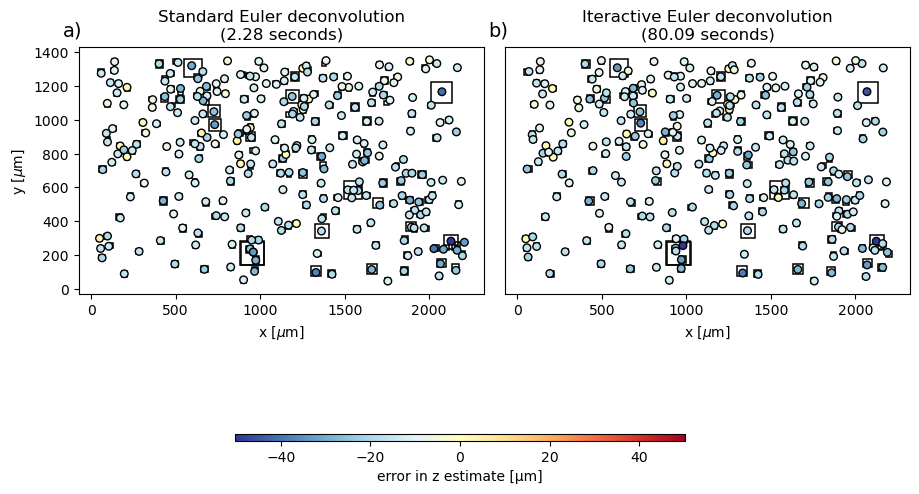

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(9, 9))
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.015, shrink=0.5)

# data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-3000, vmax=3000, add_colorbar=False)
axes = axes.ravel()

scale = vd.maxabs((positions[2]))

ax = axes[0]
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=1.1,
    )
    ax.add_patch(rect)

tmp = ax.scatter(*positions[:2], c=positions[2], cmap="RdYlBu_r", vmin=-scale, vmax=scale, s=30, edgecolor='k')

ax = axes[1]
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=1.1,
    )
    ax.add_patch(rect)

tmp = ax.scatter(*positions_itr[:2], c=positions_itr[2], cmap="RdYlBu_r", vmin=-scale, vmax=scale, s=30, edgecolor='k')

titles = ([r'Standard Euler deconvolution'   +'\n'+ f'({round(inversion_time, 2)} seconds)', 
           r'Iteractive Euler deconvolution' +'\n'+ f'({round(itr_euler_time, 2)} seconds)'])
for ax, letter, title in zip(axes, "a b".split(), titles):
    ax.text(-0.04, 1.045, f"{letter})", transform=ax.transAxes, fontsize=14)
    ax.set_aspect("equal")
    ax.set_title(title)
    ax.set_xlabel(r"x [$\mu$m]")

axes[1].set_yticks([])
axes[0].set_ylabel(r"y [$\mu$m]")
plt.tight_layout(pad=0, h_pad=0, w_pad=0.6)


fig.colorbar(tmp, **cbar_kwargs, label="error in z estimate [µm]", cax=fig.add_axes([0.25, 0.2, 0.5, 0.0075]))


plt.show()

In [25]:
fig_dir = pathlib.Path("..") / "paper" / "figures"
mpl_rc = {"text.usetex": True, "font.family": "serif", "font.size": 9}

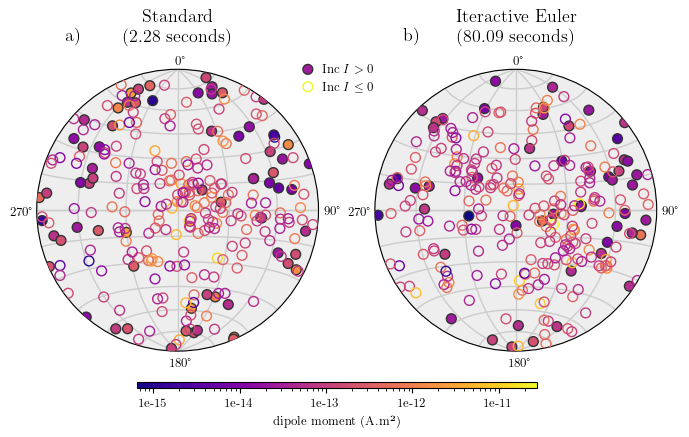

In [26]:
with plt.rc_context(mpl_rc):
    fig = plt.figure(figsize=(8, 4))
    axes = []

#     estimated = mg.vector_to_angles(estimated_dipole_moments)[2]
#     vmin = np.min(estimated)
#     vmax = np.max(estimated)
    
    estimated1 = mg.vector_to_angles(estimated_dipole_moments)[2]
    estimated2 = mg.vector_to_angles(estimated_dipole_moments_itr_euler)[2]

    
    vmin = np.min([np.min(estimated1),np.min(estimated2)])
    vmax = np.max([np.max(estimated1),np.max(estimated2)])
    
    cmap = "plasma"
    # Use matplotlib.colors.LogNorm for a log scale
    cmap_norm = matplotlib.colors.LogNorm #Normalize

        
    ## STANDARD METHOD
    ax = fig.add_subplot(1, 2, 1, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(estimated_dipole_moments, marker="o", zorder=1000, label="Inc", **kwargs)
    ax.legend(loc=(0.9, 0.9), frameon=False, handletextpad=0.1, prop = {'size' : 9})
    fig.colorbar(
        tmp, 
        cax=fig.add_axes([0.25, 0.05, 0.5, 0.015]), 
        format="%.0g",
        label="dipole moment (A.m²)",
        orientation="horizontal",
    )

    
    ## ITERACTIVE METHOD
    ax = fig.add_subplot(1, 2, 2, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(estimated_dipole_moments_itr_euler, marker="o", zorder=1000, label="Inc", **kwargs)

    
    ######
    titles = ([r'Standard'+'\n'+ f'({round(inversion_time, 2)} seconds)', 
           'Iteractive Euler'+'\n'+ f'({round(itr_euler_time, 2)} seconds)']) 
 

    for ax, letter, title in zip(axes, "a b".split(), titles):
        ax.text(0.1, 1.1, f"{letter})   ", transform=ax.transAxes, fontsize=13)
        ax.set_title(title+'\n', fontsize=13, loc='center')
    fig.subplots_adjust(wspace=0.2, hspace=0.5)

    plt.show()


# Paper's figures 

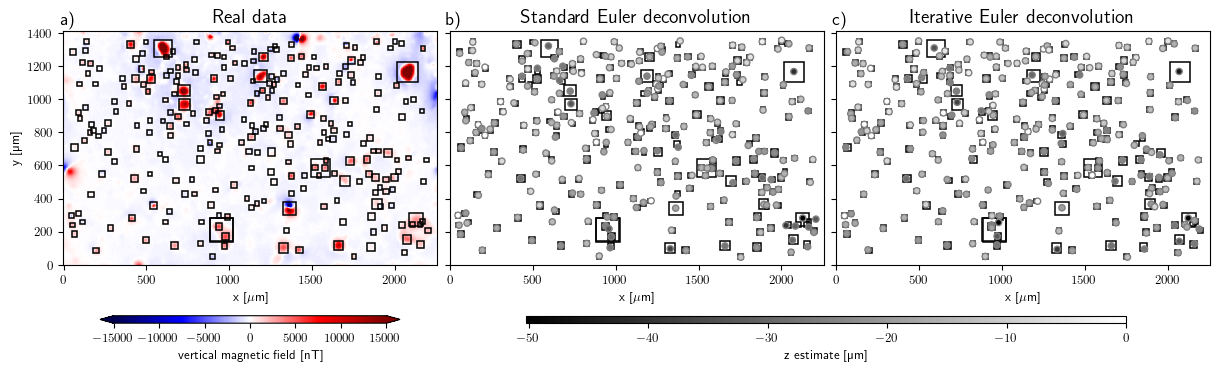

In [27]:
with plt.rc_context(mpl_rc):
    fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=True, sharex=True)
    cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.0, shrink=0.5)

    # data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-3000, vmax=3000, add_colorbar=False)
    axes = axes.ravel()

    ax = axes[0]


    tmp1 = data_up['bz'].plot.pcolormesh(ax=ax, cmap='seismic', vmin=-15000, vmax=15000, add_colorbar=False)#, cbar_kwargs=cbar_kwargs)
    for window in windows_filtered:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1.1,
        )
        ax.add_patch(rect)


    scale = vd.maxabs((positions[2]))

    ax = axes[1]
    for window in windows_filtered:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1.1,
        )
        ax.add_patch(rect)

    tmp = ax.scatter(*positions[:2], c=positions[2], s=20, cmap="gray", vmin=-scale, vmax=0, edgecolor='gray')

    ax = axes[2]
    for window in windows_filtered:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1.1,
        )
        ax.add_patch(rect)

    tmp = ax.scatter(*positions_itr[:2], c=positions_itr[2], s=20, cmap="gray", vmin=-scale, vmax=0, edgecolor='gray')

    titles = ([r'Real data',
               r'Standard Euler deconvolution', 
               r'Iterative Euler deconvolution'])
    for ax, letter, title in zip(axes, "a b c".split(), titles):
        ax.text(-0.01, 1.025, f"{letter})", transform=ax.transAxes, fontsize=13)
        ax.set_aspect("equal")
        ax.set_title(title, fontsize=14)
        ax.set_xlabel(r"x [$\mu$m]")

    plt.tight_layout(pad=0, h_pad=0, w_pad=0.6)


    fig.colorbar(tmp1, **cbar_kwargs, extend='both', label="vertical magnetic field [nT]", cax=fig.add_axes([0.075, 0.15, 0.25, 0.015]))
    fig.colorbar(tmp, **cbar_kwargs, label="z estimate [µm]", cax=fig.add_axes([0.43, 0.15, 0.5, 0.015]))
    # fig.savefig(fig_dir/"euler-comparion-real.png", dpi=300, facecolor='w', bbox_inches='tight')
    
plt.show()


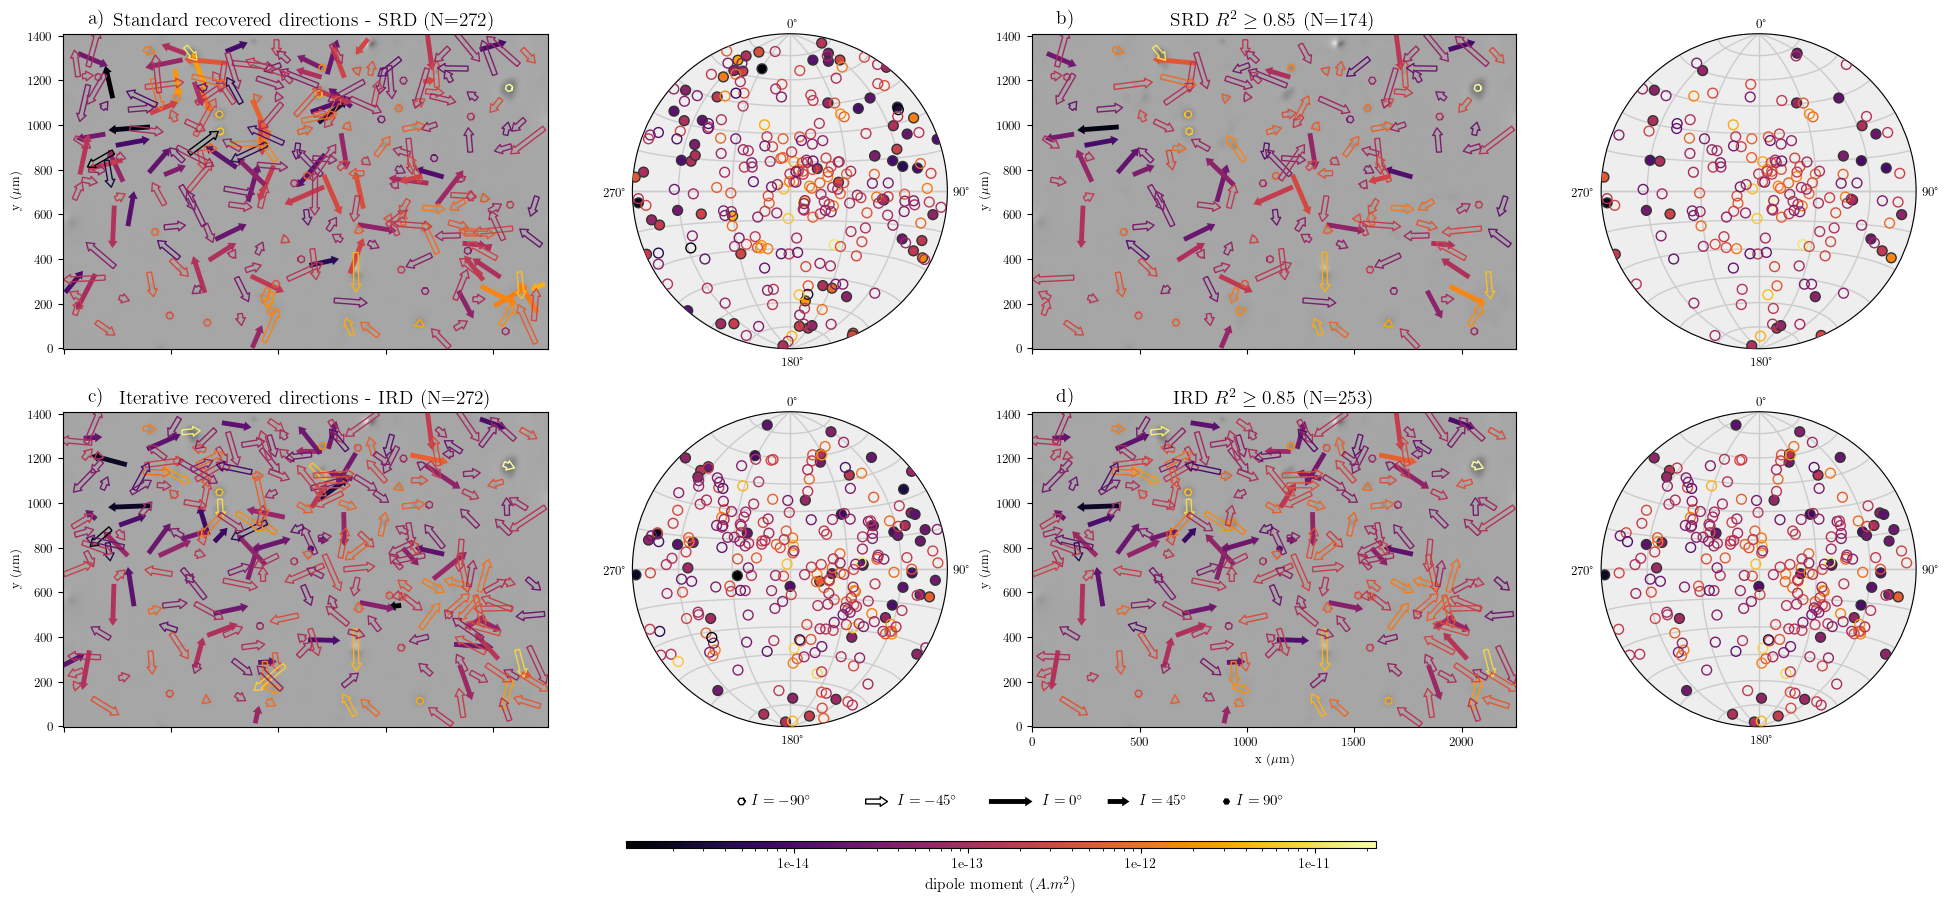

In [28]:
import warnings
warnings.filterwarnings('ignore')

r_square_filter = 0.85

with plt.rc_context(mpl_rc):
    fig = plt.figure(figsize=(25, 9))
    
    axes = []

    estimated = mg.vector_to_angles(estimated_dipole_moments)[2]
    vmin = np.min(estimated)
    vmax = np.max(estimated)
    cmap = "inferno"
    # Use matplotlib.colors.LogNorm for a log scale
    cmap_norm = matplotlib.colors.LogNorm #Normalize
    
#################################################################################################
#                                             Maps
#################################################################################################
    #1
    ax = fig.add_subplot(2, 4, 1)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    scale = 50000
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        positions, estimated_dipole_moments, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_ylabel("y ($\mu$m)")
    plt.xticks(color='w', alpha=0.0)

    pos_filter= ( (np.array(calculated_r2) > r_square_filter) & (np.array(calculated_SNR) > 5))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,2][pos_filter] 
                                     ]).T
    
    filter_positions = np.array( [np.array(positions)[0][pos_filter], 
                                  np.array(positions)[1][pos_filter], 
                                  np.array(positions)[2][pos_filter]
                                 ])
    #2
    ax = fig.add_subplot(2, 4, 3)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        filter_positions, filter_estimated_d_m, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_ylabel("y ($\mu$m)")
    plt.xticks(color='w', alpha=0.0)
    
#     clb = fig.colorbar(
#         tmp, 
#         cax=fig.add_axes([0.25, 0.05, 0.5, 0.0075]), 
#         format="%.0g",
# #         label="dipole moment (A.m²)",
#         orientation="horizontal"
#     )
    
#     clb.set_label(label="dipole moment ($A.m^2$)", fontsize=11)
    
#     clb.ax.tick_params(labelsize=10)


    #3
    ax = fig.add_subplot(2, 4, 5)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        positions, estimated_dipole_moments_itr_euler, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_ylabel("y ($\mu$m)")
    plt.xticks(color='w', alpha=0.0)


    pos_filter= ( (np.array(calculated_r2_itr_euler) > r_square_filter))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments_itr_euler)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments_itr_euler)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments_itr_euler)[:,2][pos_filter] 
                                     ]).T
    
    filter_positions = np.array( [np.array(positions)[0][pos_filter], 
                                  np.array(positions)[1][pos_filter], 
                                  np.array(positions)[2][pos_filter]
                                 ])
    #4
    ax = fig.add_subplot(2, 4, 7)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        filter_positions, filter_estimated_d_m, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )

    ax.set_ylabel("y ($\mu$m)")
    ax.set_xlabel("x ($\mu$m)")

    
    clb = fig.colorbar(
        tmp, 
        # cax=fig.add_axes([0.12, -0.025, 0.73, 0.0075]), 
        cax=fig.add_axes([0.35, -0.025, 0.3, 0.0075]), 
        format="%.0g",
#         label="dipole moment (A.m²)",
        orientation="horizontal"
    )
    
    clb.set_label(label="dipole moment ($A.m^2$)", fontsize=11)
    
    clb.ax.tick_params(labelsize=10)
#################################################################################################
#                                           Stereograms
#################################################################################################
    #1
    ax = fig.add_subplot(2, 4, 2, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    
    tmp = mg.plot_stereonet(estimated_dipole_moments, marker="o", zorder=1000, label="Inc", **kwargs, add_ticks=True)
    
    N1 = np.asarray(estimated_dipole_moments).shape[0]
    
    pos_filter= ( (np.array(calculated_r2) > r_square_filter) & (np.array(calculated_SNR) > 5))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,2][pos_filter]
                                     ]).T

    N2 = filter_estimated_d_m.shape[0]
    #2
    ax = fig.add_subplot(2, 4, 4, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(filter_estimated_d_m, marker="o", zorder=1000, **kwargs, add_ticks=True)


    #3
    ax = fig.add_subplot(2, 4, 6, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    
    tmp = mg.plot_stereonet(estimated_dipole_moments_itr_euler, marker="o", zorder=1000, label="Inc", **kwargs, add_ticks=True)
    
    N3 = np.asarray(estimated_dipole_moments_itr_euler).shape[0]
    
    pos_filter= ( (np.array(calculated_r2_itr_euler) > r_square_filter))

    filter_estimated_d_m_itr = np.array( [np.array(estimated_dipole_moments_itr_euler)[:,0][pos_filter], 
                                          np.array(estimated_dipole_moments_itr_euler)[:,1][pos_filter], 
                                          np.array(estimated_dipole_moments_itr_euler)[:,2][pos_filter]
                                         ]).T
    
    N4 = filter_estimated_d_m_itr.shape[0]
    #4
    ax = fig.add_subplot(2, 4, 8, projection='stereonet')
    axes.append(ax)   

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(filter_estimated_d_m_itr, marker="o", zorder=1000, **kwargs, add_ticks=True)
    # ax.legend(loc=(-0.35, -0.05), frameon=False, handletextpad=0.1, prop = {'size' : 12})


    # Inc values seem to be reversed because the function uses 90 - inc to plot instead of inc.
    ax.quiverkey(negquiver,-0.6, -0.235, 0., label="$I = -90^\circ$", labelpos="E", edgecolor='k', 
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(negquiver, -0.3, -0.235, 45, label="$I = -45^\circ$", labelpos="E", edgecolor='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.0, -0.235, 90, label="$I =   0^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.2, -0.235, 45, label="$I =  45^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.4, -0.235, 0., label="$I =  90^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    
    titles = (f'Standard recovered directions - SRD (N={N1})', f'SRD $R^2 \geq {r_square_filter}$ (N={N2})',
              f'Iterative recovered directions - IRD (N={N3})', f'IRD $R^2 \geq {r_square_filter}$ (N={N4})')

    for ax, letter, title in zip(axes, "a b c d".split(), titles):
        ax.text(0.05, 1.031, f"{letter})", transform=ax.transAxes, fontsize=14)
        ax.set_title(title, fontsize=14)
        ax.set_aspect("auto")
    
        
    fig.subplots_adjust(wspace=0.0, hspace=0.2)
    # fig.savefig(fig_dir/"real-data-stereograms.png", dpi=300, facecolor='w', bbox_inches='tight')
    # fig.savefig("real-data-stereograms.pdf", dpi=300, facecolor='w', bbox_inches='tight')
    plt.show()

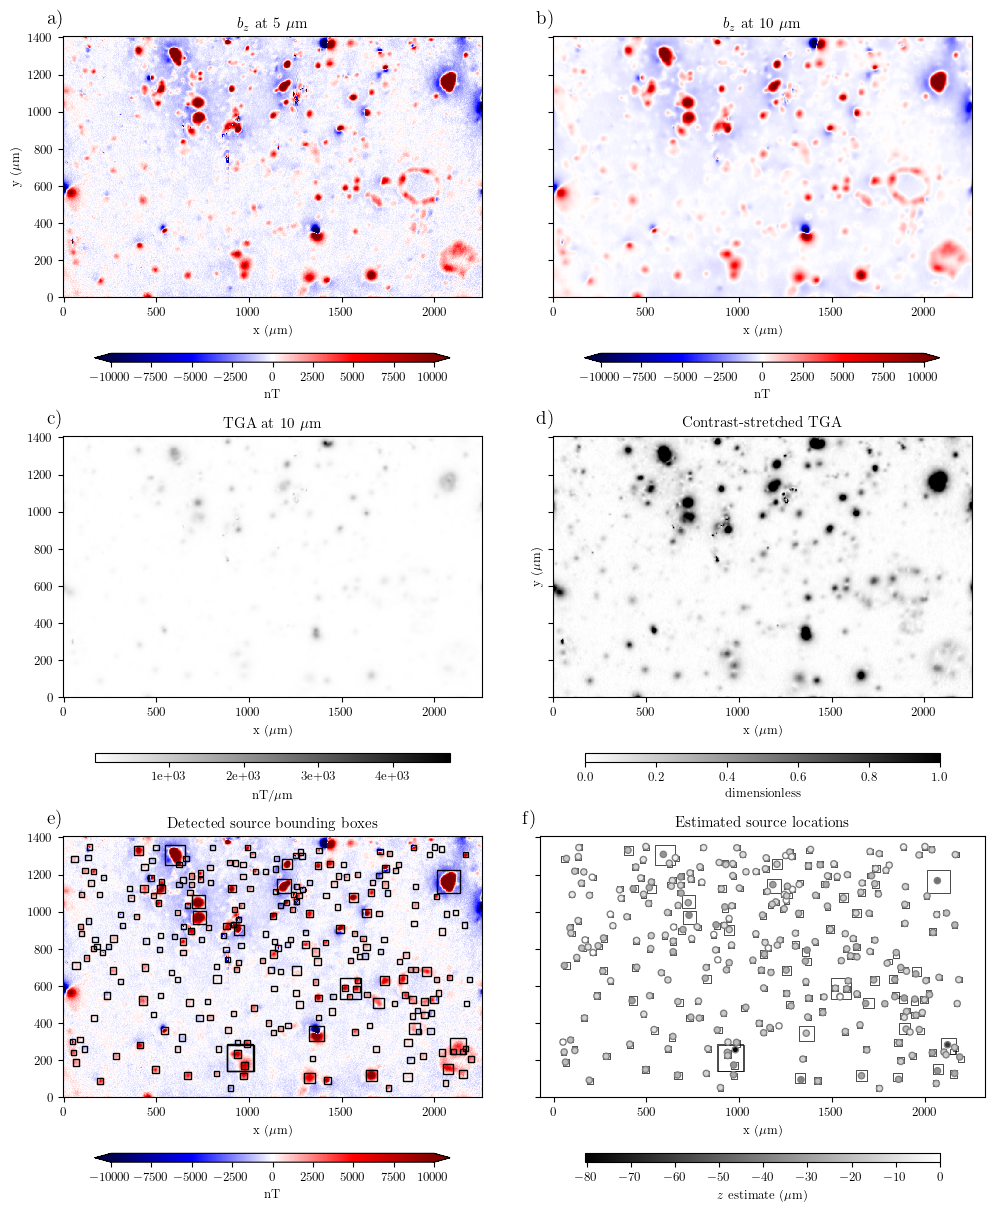

In [29]:
sensor_sample_distance = float(data.z.values.mean())
vmax=+10000
vmin=-10000
with plt.rc_context(mpl_rc):

    fig, axes = plt.subplots(3, 2, figsize=(12, 12), sharey="row")
    axes = axes.ravel()    
    cbar_kwargs = dict(orientation="horizontal", aspect=40, pad=0.15, shrink=0.5)
    
    ax = axes[0]
    ax.set_aspect("equal")
    ax.set_title(f"$b_z$ at {sensor_sample_distance:.0f} $\mu$m")
    ax.set_xlabel("x ($\mu$m)")
    ax.set_ylabel("y ($\mu$m)")
    tmp = data.bz.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False, vmax=vmax, vmin=vmin)
    fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
    

    ax = axes[1]
    ax.set_aspect("equal")
    ax.set_title(f"$b_z$ at {sensor_sample_distance + height_difference:.0f} $\mu$m")
    ax.set_xlabel("x ($\mu$m)")
    tmp = data_up.bz.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False, vmax=vmax, vmin=vmin)
    fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
    
    ax = axes[2]   
    ax.set_aspect("equal")
    ax.set_title(f"TGA at {sensor_sample_distance + height_difference:.0f} $\mu$m")
    ax.set_xlabel("x ($\mu$m)")
    tmp = data_up.tga.plot.pcolormesh(ax=ax, cmap="gray_r", add_colorbar=False, add_labels=False)
    fig.colorbar(tmp, ax=ax, label="nT/$\mu$m", **cbar_kwargs, format="%.0e")
    
    ax = axes[3]  
    ax.set_aspect("equal")
    ax.set_title(f"Contrast-stretched TGA")
    ax.set_xlabel("x ($\mu$m)")
    ax.set_ylabel("y ($\mu$m)")
    tmp = data_up.tga_stretched.plot.pcolormesh(ax=ax, cmap="gray_r", add_colorbar=False, add_labels=False)
    fig.colorbar(tmp, ax=ax, label="dimensionless", **cbar_kwargs)
    
    ax = axes[4]  
    ax.set_aspect("equal")
    ax.set_title(f"Detected source bounding boxes")
    ax.set_xlabel("x ($\mu$m)")
    tmp = data.bz.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False, vmax=vmax, vmin=vmin)
    fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')    
    for window in windows_filtered:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1,
        )
        ax.add_patch(rect)   
    
        
    ax = axes[5]  
    ax.set_aspect("equal")
    ax.set_title(f"Estimated source locations")
    ax.set_xlabel("x ($\mu$m)")
    scale = 100
#     tmp = data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r",  add_colorbar=False, add_labels=False)
    for window in windows_filtered:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=0.5,
        )
        ax.add_patch(rect)
    scale = vd.maxabs(positions_itr[2])
    tmp = ax.scatter(*positions_itr[:2], c=positions_itr[2], s=20, cmap="gray", vmin=-scale, vmax=0, edgecolor='gray')
    fig.colorbar(tmp, ax=ax, label="$z$ estimate ($\mu$m)", **cbar_kwargs)    
    
    for ax, letter in zip(axes, "a b c d e f".split()):
        ax.text(-0.04, 1.045, f"{letter})", transform=ax.transAxes, fontsize=14)

    plt.tight_layout(pad=0, h_pad=0, w_pad=-10)
    
    # fig.savefig("processing_steps.png", dpi=300, facecolor='w', bbox_inches='tight')
    
    plt.show()

In [30]:
data_up_copy = (
            hm.upward_continuation(data_copy.bz, height_difference)
            .assign_attrs(data_copy.bz.attrs)
            .to_dataset(name="bz")
            .assign_coords(x=data_copy.x, y=data_copy.y)
            .assign_coords(z=data_copy.z + height_difference)
               )


In [31]:
data_up_copy = data_up_copy.assign(mg.data_gradients(data_up_copy.bz))
data_up_copy

<xarray.Dataset> Size: 28MB
Dimensions:  (y: 600, x: 960)
Coordinates:
  * x        (x) float64 8kB 0.0 2.35 4.7 7.05 ... 2.249e+03 2.251e+03 2.254e+03
  * y        (y) float64 5kB 0.0 2.35 4.7 7.05 ... 1.403e+03 1.405e+03 1.408e+03
    z        (y, x) float64 5MB 10.0 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz       (y, x) float64 5MB 253.3 302.9 323.1 335.6 ... 135.2 162.6 192.0
    tga      (y, x) float64 5MB 39.55 51.85 40.49 39.45 ... 11.02 17.36 17.42
    x_deriv  (y, x) float64 5MB 21.08 14.85 6.957 3.596 ... 8.504 12.1 12.52
    y_deriv  (y, x) float64 5MB 0.4533 3.429 6.569 9.265 ... -6.745 -2.194 3.873
    z_deriv  (y, x) float64 5MB -33.46 -49.56 -39.35 ... -1.922 -12.25 -11.48

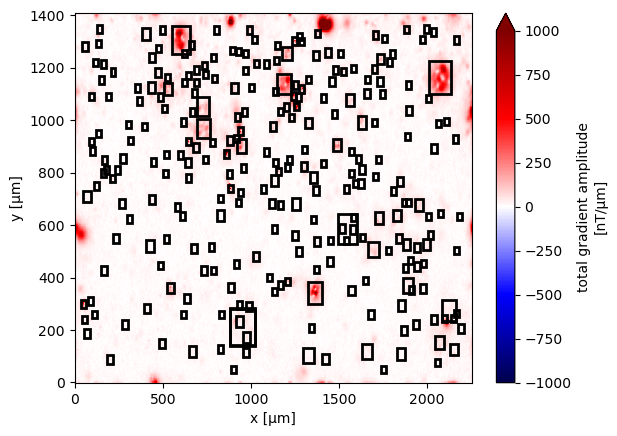

In [32]:
ax = plt.subplot(111)
scale=1000
data_up_copy.tga.plot.pcolormesh(ax=ax, cmap="seismic", vmin=-scale, vmax=scale)
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)   

In [33]:
stretched = skimage.exposure.rescale_intensity(
    data_up_copy.tga, 
    in_range=tuple(np.percentile(data_up_copy.tga, (1, 99))),
)
data_up_copy = data_up_copy.assign(tga_stretched=xr.DataArray(stretched, coords=data_up.coords))

In [34]:
start_detection_time = time.perf_counter()

windows_new = mg.detect_anomalies(
    data_up_copy.tga_stretched, 
    size_range=[20,150],
    size_increment=1.3,
    threshold=0.11,
    overlap=0.0,
    exclude_border=15
)
# windows
end_detection_time = time.perf_counter()

In [35]:
detection_time = end_detection_time-start_detection_time
print(f'{np.shape(windows_new)[0]} potential sources detected within {round(detection_time, 4)} seconds', )

66 potential sources detected within 1.2943 seconds


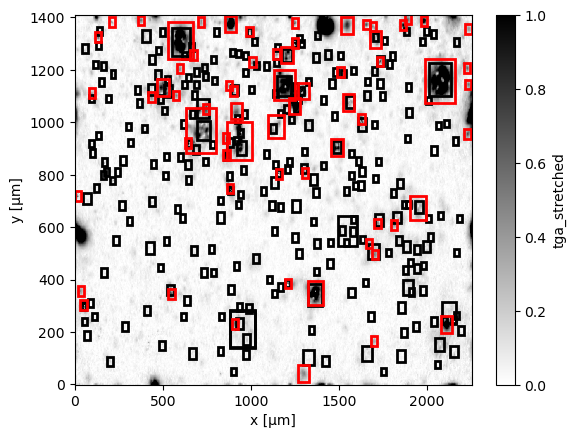

In [36]:
ax = plt.subplot(111)
data_up_copy = data_up_copy.assign(tga_stretched=xr.DataArray(stretched, coords=data_up_copy.coords))
data_up_copy.tga_stretched.plot.pcolormesh(cmap="gray_r")

for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)

for window in windows_new:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="r",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)

In [37]:
def intersects(window1, window2):
    # Verifica se há sobreposição horizontal
    horizontal_overlap = (window1[0] <= window2[1]) and (window2[0] <= window1[1])
    # Verifica se há sobreposição vertical
    vertical_overlap = (window1[2] <= window2[3]) and (window2[2] <= window1[3])
    return horizontal_overlap and vertical_overlap
    


# Remove overlapping windows
non_overlapping_windows = np.copy(windows_new)

for window in windows:
    non_overlapping_windows = [nw for nw in non_overlapping_windows if not intersects(nw, window)]

print("Non-overlapping windows:")
for window in non_overlapping_windows:
    print(window)

Non-overlapping windows:
[ 854.28732969  917.61267031 1343.08732969 1406.41267031]
[1965.01522369 2001.78477631 1368.11522369 1404.88477631]
[1514.63732969 1577.96267031 1338.38732969 1401.71267031]
[1638.36522369 1675.13477631 1354.01522369 1390.78477631]
[1231.81522369 1268.58477631 1361.06522369 1397.83477631]
[2211.76522369 2248.53477631 1189.51522369 1226.28477631]
[ 357.61522369  394.38477631 1370.46522369 1407.23477631]
[2214.11522369 2250.88477631  935.71522369  972.48477631]
[ -1.93477631  34.83477631 700.71522369 737.48477631]
[1267.88732969 1331.21267031   10.63732969   73.96267031]
[ 14.51522369  51.28477631 338.81522369 375.58477631]
[ 698.36522369  735.13477631 1363.41522369 1400.18477631]
[2216.46522369 2253.23477631 1126.06522369 1162.83477631]
[ 578.51522369  615.28477631 1187.16522369 1223.93477631]
[1875.71522369 1912.48477631 1375.16522369 1411.93477631]
[ 555.01522369  591.78477631 1083.76522369 1120.53477631]
[1675.96522369 1712.73477631 1346.96522369 1383.7347763

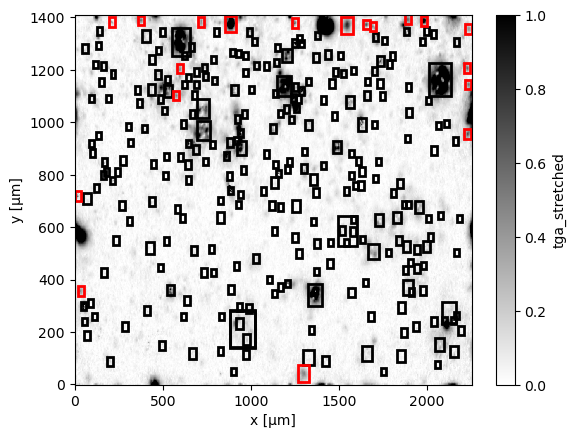

In [38]:
ax = plt.subplot(111)
data_up_copy = data_up_copy.assign(tga_stretched=xr.DataArray(stretched, coords=data_up_copy.coords))
data_up_copy.tga_stretched.plot.pcolormesh(cmap="gray_r")

for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)
for window in non_overlapping_windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="r",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)

In [39]:
import warnings
import rich.progress

warnings.filterwarnings("ignore")

start_itr_euler_time = time.perf_counter()

data_copy_2 = data_copy.copy(deep=True)
data_up_copy_2 = data_up_copy.copy(deep=True)

positions_itr_enhanced = list(np.copy(positions_itr))
estimated_dipole_moments_itr_euler_enhanced = list(np.copy(estimated_dipole_moments_itr_euler))
windows_enhanced = list(np.copy(windows))
calculated_r2_itr_euler_enhanced = list(np.copy(calculated_r2_itr_euler))
base_levels_itr_euler_enhanced = list(np.copy(base_levels_itr_euler))

#################################
for window in rich.progress.track(np.array(non_overlapping_windows), total = len(np.array(non_overlapping_windows))):
    anomaly = data_up_copy_2.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )
    
    data_minus_background = anomaly.bz.values - base_level 
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}

    base_levels_itr_euler_enhanced.append(base_level)
    moment, covariance, r2, SNR = mg.dipole_moment_inversion(anomaly.data_minus_background, position)

    ## SCIPY MINIMIZATION

    anomaly_table=vd.grid_to_table(anomaly)
    amplitude = np.linalg.norm(moment)
    args=(data_minus_background.ravel(), 
         ( anomaly_table.x.values,
           anomaly_table.y.values, 
           anomaly.z.values.ravel()),
          amplitude, position[0], position[1], position[2])
    
    minimization=sp.optimize.minimize(goal_function, (1, 1, 1,
                                                      moment[0]/amplitude,
                                                      moment[1]/amplitude,
                                                      moment[2]/amplitude),
                                      
                                      args=args,
                                      
                                        method='Nelder-Mead', options=dict(fatol=1.0e-8))
    
    # print(minimization.x[0])
    if minimization.success:
        
        moment = np.array([minimization['x'][3], minimization['x'][4], minimization['x'][5]])*amplitude
        position = np.array([minimization['x'][0]*position[0], 
                             minimization['x'][1]*position[1],
                             minimization['x'][2]*position[2]])
        xxx, yyy = np.meshgrid(anomaly.x.values, anomaly.y.values)
        zzz = anomaly.z.values.ravel()
        pred = mg.dipole_bz([xxx, yyy, zzz], 
                  position,
                  moment
                 )
        
        residuals = data_minus_background.ravel() - pred.ravel()
        residuals_sum_sq = np.sum(residuals**2)
        r2 = 1 - residuals_sum_sq / np.linalg.norm(data_minus_background.ravel() - np.mean(data_minus_background.ravel())) ** 2
    else:
        print('piorou')


    windows_enhanced.append(window)
    estimated_dipole_moments_itr_euler_enhanced.append(moment)
    for i in range(3):
        positions_itr_enhanced[i]=np.append(positions_itr_enhanced[i], position[i])
    calculated_r2_itr_euler_enhanced.append(r2)
    # estimated_dipole_moments_itr_euler.append(moment)
    print(position)
    print(moment)
    print(mg.vector_to_angles(moment))
    print(r2)
    print()
    #########
    
    discard = mg.dipole_bz(coordinates, position, moment)

    data_copy_2.bz.values -= discard
    
#     print(discard.max())
    data_up_copy_2 = (
                hm.upward_continuation(data_copy_2.bz, height_difference)
                .assign_attrs(data_copy_2.bz.attrs)
                .to_dataset(name="bz")
                .assign_coords(x=data_copy_2.x, y=data_copy_2.y)
                .assign_coords(z=data_copy_2.z + height_difference)
                   )
    
    
    data_up_copy_2 = data_up_copy_2.assign(mg.data_gradients(data_up_copy_2.bz))
    
    
    ########
    # Filter out solutions that don't meet quality criteria
    bad_euler = False #position[2] > 0.0
    poor_fit =  False # r2 < 0.85  

    if bad_euler or poor_fit:
        continue


end_itr_euler_time = time.perf_counter()
warnings.resetwarnings()

Output()

[ 887.19444112 1379.27350656  -11.29516674]

[-1.18377426e-13 -2.75264674e-13  4.85139139e-13]

(-58.29901652789581, -156.72990325415375, 5.702138546421477e-13)

0.9731935041232592

[1983.39367919 1385.04143244   -9.82970076]

[-3.80995024e-15  3.63702950e-14  9.22571382e-14]

(-68.37738995070056, -5.980177026219689, 9.924058455164806e-14)

0.9313211159464685

[1546.02548173 1376.08634549  -24.56844977]

[ 9.86938982e-14 -3.15163243e-13  5.21997145e-13]

(-57.679451192095854, 162.6119652253096, 6.1769683059223e-13)

0.9878087532765257

[1655.29460069 1371.51742914   -7.70407422]

[8.38504509e-15 2.15412422e-14 2.58233235e-14]

(-48.166784422411226, 21.26874466794734, 3.465801686861763e-14)

0.9873609856067043

[1247.21251198 1381.39372441   -5.38832095]

[ 2.10054836e-14 -1.47343689e-14  1.31806773e-15]

(-2.9407377640514265, 125.04787224136865, 2.5691813260270555e-14)

0.9219414071844302

[2224.70371873 1212.96527915  -13.78252561]

[ 5.74076472e-14 -8.51912323e-14  4.14882800e-14]

(-21.991941811506152, 146.025229924258, 1.1079016827065524e-13)

0.9805905366554312

[ 372.97350785 1384.63293529  -12.75653876]

[ 2.45437465e-14 -5.18765018e-14 -4.20263009e-14]

(36.21524782074127, 154.68029027898658, 7.113210874210321e-14)

0.9536333212658525

piorou

[2218.81122445  925.84785232  -17.84793334]

[ 7.81370750e-14 -4.46589892e-13  4.57183361e-13]

(-45.23970170287625, 170.07576569390184, 6.438668804540796e-13)

0.24247301482470818

[ 13.25139774 718.62726215  -4.40042768]

[ 5.11023099e-15 -5.07812050e-15  5.38401512e-15]

(-36.772040683643645, 134.81942221367945, 8.993852755705342e-15)

0.8052727027524759

[1284.99290466   46.54744201  -35.17942097]

[ 4.64494145e-13 -6.41864182e-13  6.22620851e-13]

(-38.161557607125935, 144.10808589940694, 1.007671158591786e-12)

0.918193767655415

[ 29.79419255 357.07794182 -18.30601727]

[ 4.09207102e-14 -4.40748570e-14  1.16518684e-13]

(-62.699016416773354, 137.12524509449466, 1.3112475498902505e-13)

0.9861759015085022

piorou

[ 707.43738926 1382.42822783  -14.40105545]

[ 1.04064557e-13 -2.18533803e-14  4.65627867e-15]

(-2.50732425873043, 101.85968590466825, 1.0643628732733288e-13)

0.7953866204139808

[2238.24246434 1139.09910998  -15.78660975]

[ 9.76663839e-14  9.33205834e-14 -1.18183363e-14]

(5.000039245514511, 46.303508143056014, 1.3559914049880175e-13)

0.8938799032699015

[ 587.16129506 1204.57361748  -15.52439789]

[ 1.11874375e-13 -1.39915744e-14  3.75989895e-14]

(-18.44273284256093, 97.1286861495328, 1.188500060058149e-13)

0.9140355844866589

piorou

[1897.47741303 1408.67601246  -20.87839197]

[-2.97921159e-14 -3.89808754e-13 -1.71385493e-13]

(23.67202536748255, -175.62952207477704, 4.2686229841247907e-13)

0.7168290736916489

[ 570.30898886 1104.22910011  -11.37362696]

[ 7.48078455e-14 -2.38859689e-15 -2.69036733e-15]

(2.0586326309803966, 91.82881941437672, 7.489430701510853e-14)

0.8984825696149374

[1696.34017369 1365.08211755   -5.17706266]

[ 1.51408993e-14 -9.12569224e-15 -6.22368160e-15]

(19.394641077930547, 121.07812564318046, 1.8741913033346224e-14)

0.8820958792603191

[2233.38550968 1356.50815892  -16.30010697]

[1.10206656e-13 9.27349324e-15 4.55899174e-14]

(-22.402426950201797, 85.1900974907488, 1.196241836732886e-13)

0.9828510150106604

[ 205.45098176 1380.39375226   -8.14841282]

[1.47169798e-14 4.60388493e-15 9.80537051e-15]

(-32.45124890863839, 72.62885032271207, 1.827376647874801e-14)

0.9526539020522979

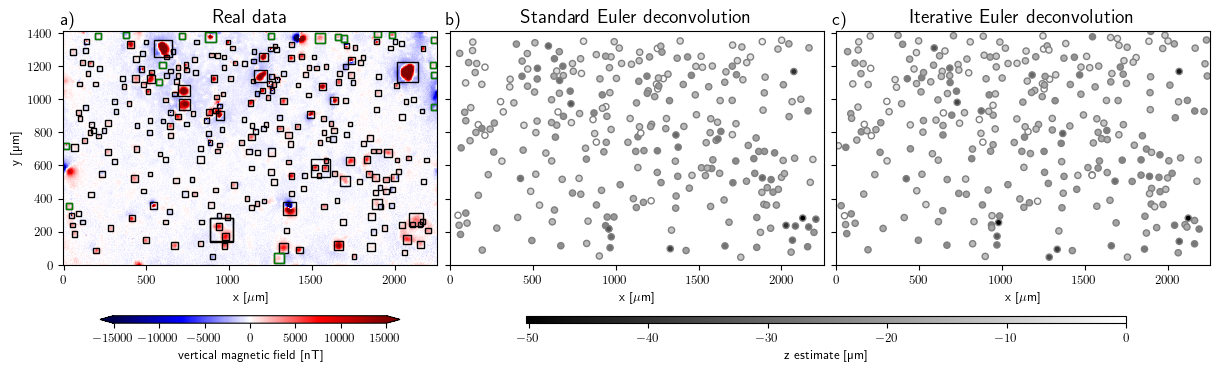

In [40]:
with plt.rc_context(mpl_rc):
    fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=True, sharex=True)
    cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.0, shrink=0.5)

    axes = axes.ravel()

    ax = axes[0]
    tmp1 = data['bz'].plot.pcolormesh(ax=ax, cmap='seismic', vmin=-15000, vmax=15000, add_colorbar=False)#, cbar_kwargs=cbar_kwargs)
    for window in windows_enhanced:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1,
        )
        ax.add_patch(rect)

    for window in non_overlapping_windows:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="g",
            fill=False,
            linewidth=1,
        )
        ax.add_patch(rect)


    scale = vd.maxabs((positions[2]))

    ax = axes[1]
    tmp = ax.scatter(*positions[:2], c=positions[2], s=20, cmap="gray", vmin=-scale, vmax=0, edgecolor='gray')

    ax = axes[2]
    tmp = ax.scatter(*positions_itr_enhanced[:2], c=positions_itr_enhanced[2], s=20, cmap="gray", vmin=-scale, vmax=0, edgecolor='gray')

    titles = ([r'Real data',
               r'Standard Euler deconvolution', 
               r'Iterative Euler deconvolution'])
    for ax, letter, title in zip(axes, "a b c".split(), titles):
        ax.text(-0.01, 1.025, f"{letter})", transform=ax.transAxes, fontsize=13)
        ax.set_aspect("equal")
        ax.set_title(title, fontsize=14)
        ax.set_xlabel(r"x [$\mu$m]")

    plt.tight_layout(pad=0, h_pad=0, w_pad=0.6)


    fig.colorbar(tmp1, **cbar_kwargs, extend='both', label="vertical magnetic field [nT]", cax=fig.add_axes([0.075, 0.15, 0.25, 0.015]))
    fig.colorbar(tmp, **cbar_kwargs, label="z estimate [µm]", cax=fig.add_axes([0.43, 0.15, 0.5, 0.015]))
    # fig.savefig(fig_dir / "euler-comparion-real.png", dpi=300, facecolor='w', bbox_inches='tight')
    
plt.show()


<>:32: DeprecationWarning: invalid escape sequence '\m'
<>:58: DeprecationWarning: invalid escape sequence '\m'
<>:74: DeprecationWarning: invalid escape sequence '\m'
<>:102: DeprecationWarning: invalid escape sequence '\m'
<>:103: DeprecationWarning: invalid escape sequence '\m'
<>:183: DeprecationWarning: invalid escape sequence '\c'
<>:185: DeprecationWarning: invalid escape sequence '\c'
<>:187: DeprecationWarning: invalid escape sequence '\c'
<>:189: DeprecationWarning: invalid escape sequence '\c'
<>:191: DeprecationWarning: invalid escape sequence '\c'
<>:194: DeprecationWarning: invalid escape sequence '\g'
<>:195: DeprecationWarning: invalid escape sequence '\g'
<>:32: DeprecationWarning: invalid escape sequence '\m'
<>:58: DeprecationWarning: invalid escape sequence '\m'
<>:74: DeprecationWarning: invalid escape sequence '\m'
<>:102: DeprecationWarning: invalid escape sequence '\m'
<>:103: DeprecationWarning: invalid escape sequence '\m'
<>:183: DeprecationWarning: invalid e

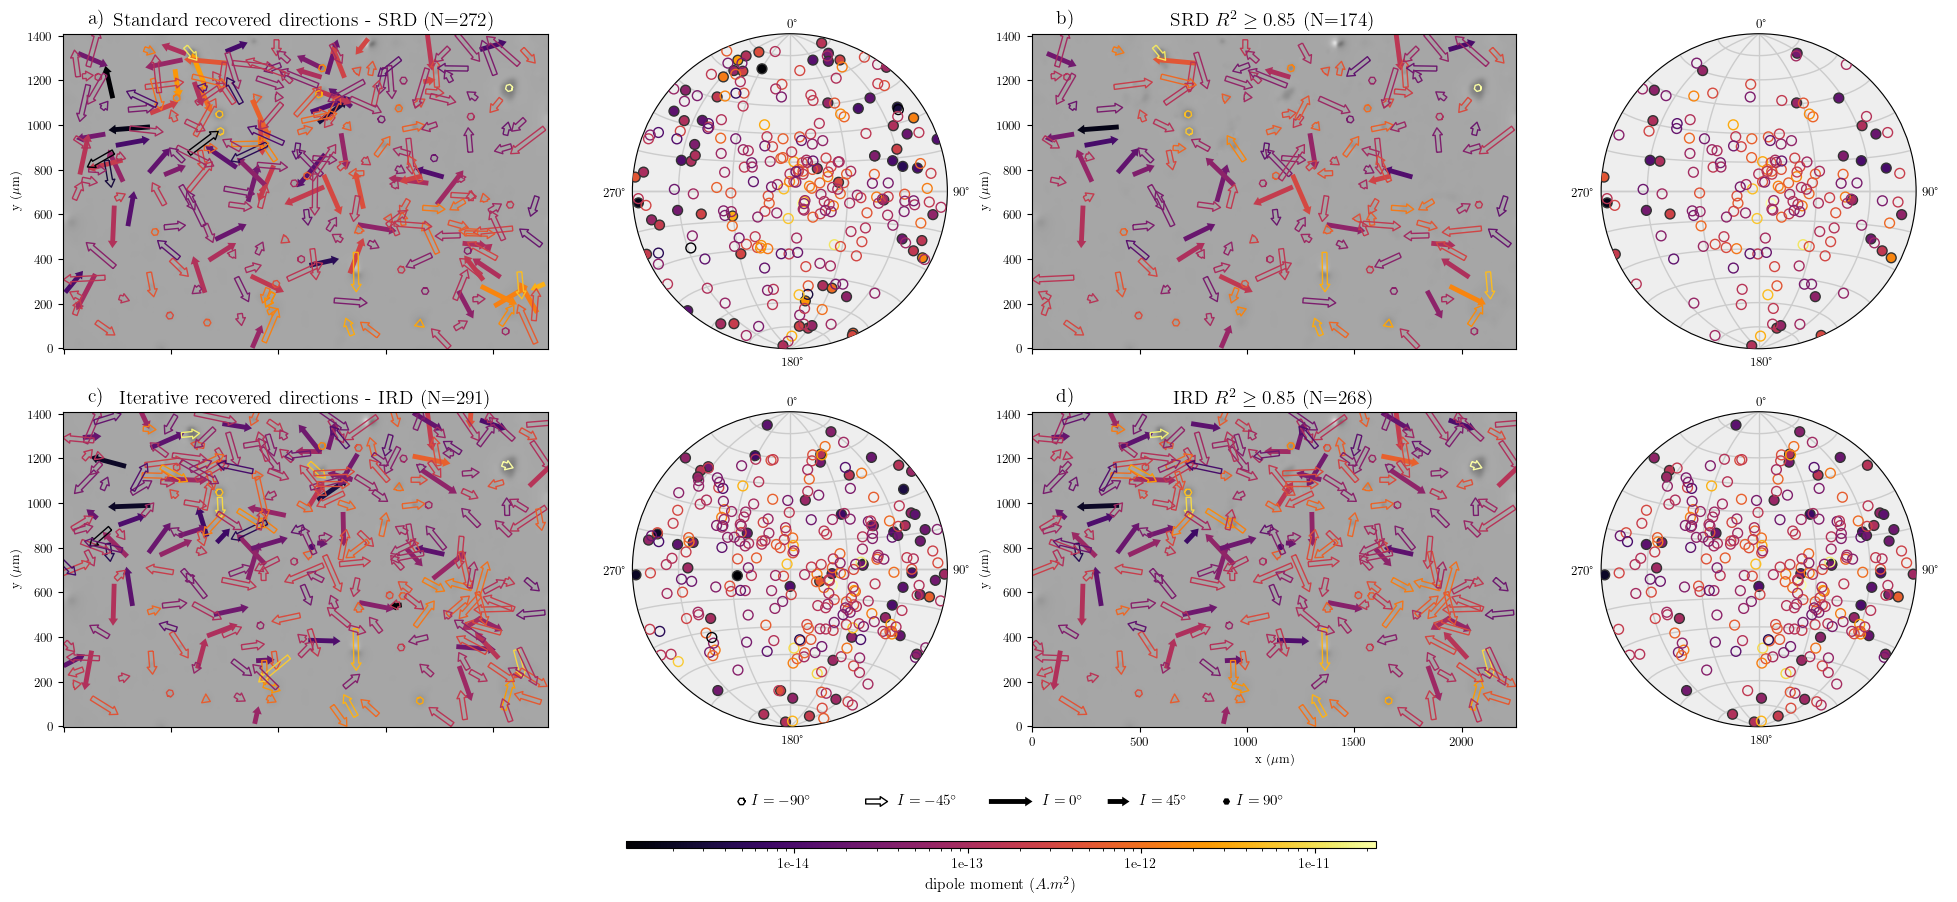

In [41]:
import warnings
warnings.filterwarnings('ignore')

with plt.rc_context(mpl_rc):
    fig = plt.figure(figsize=(25, 9))
    
    axes = []

    estimated = mg.vector_to_angles(estimated_dipole_moments)[2]
    vmin = np.min(estimated)
    vmax = np.max(estimated)
    cmap = "inferno"
    # Use matplotlib.colors.LogNorm for a log scale
    cmap_norm = matplotlib.colors.LogNorm #Normalize
    
#################################################################################################
#                                             Maps
#################################################################################################
    #1
    ax = fig.add_subplot(2, 4, 1)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    scale = 50000
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        positions, estimated_dipole_moments, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_ylabel("y ($\mu$m)")
    plt.xticks(color='w', alpha=0.0)

    pos_filter= ( (np.array(calculated_r2) > 0.85) & (np.array(calculated_SNR) > 5))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,2][pos_filter] 
                                     ]).T
    
    filter_positions = np.array( [np.array(positions)[0][pos_filter], 
                                  np.array(positions)[1][pos_filter], 
                                  np.array(positions)[2][pos_filter]
                                 ])
    #2
    ax = fig.add_subplot(2, 4, 3)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        filter_positions, filter_estimated_d_m, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_ylabel("y ($\mu$m)")
    plt.xticks(color='w', alpha=0.0)
    

    #3
    ax = fig.add_subplot(2, 4, 5)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        positions_itr_enhanced, estimated_dipole_moments_itr_euler_enhanced, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_ylabel("y ($\mu$m)")
    plt.xticks(color='w', alpha=0.0)


    pos_filter= ( (np.array(calculated_r2_itr_euler_enhanced) > 0.85))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments_itr_euler_enhanced)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments_itr_euler_enhanced)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments_itr_euler_enhanced)[:,2][pos_filter] 
                                     ]).T
    
    filter_positions = np.array( [np.array(positions_itr_enhanced)[0][pos_filter], 
                                  np.array(positions_itr_enhanced)[1][pos_filter], 
                                  np.array(positions_itr_enhanced)[2][pos_filter]
                                 ])
    #4
    ax = fig.add_subplot(2, 4, 7)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        filter_positions, filter_estimated_d_m, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=1000, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )

    ax.set_ylabel("y ($\mu$m)")
    ax.set_xlabel("x ($\mu$m)")

    
    clb = fig.colorbar(
        tmp, 
        # cax=fig.add_axes([0.12, -0.025, 0.73, 0.0075]), 
        cax=fig.add_axes([0.35, -0.025, 0.3, 0.0075]), 
        format="%.0g",
#         label="dipole moment (A.m²)",
        orientation="horizontal"
    )
    
    clb.set_label(label="dipole moment ($A.m^2$)", fontsize=11)
    
    clb.ax.tick_params(labelsize=10)
#################################################################################################
#                                           Stereograms
#################################################################################################
    #1
    ax = fig.add_subplot(2, 4, 2, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    
    tmp = mg.plot_stereonet(estimated_dipole_moments, marker="o", zorder=1000, label="Inc", **kwargs, add_ticks=True)
    
    N1 = np.asarray(estimated_dipole_moments).shape[0]
    
    pos_filter= ( (np.array(calculated_r2) > 0.85) & (np.array(calculated_SNR) > 5))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,2][pos_filter]
                                     ]).T

    N2 = filter_estimated_d_m.shape[0]
    #2
    ax = fig.add_subplot(2, 4, 4, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(filter_estimated_d_m, marker="o", zorder=1000, **kwargs, add_ticks=True)


    #3
    ax = fig.add_subplot(2, 4, 6, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    
    tmp = mg.plot_stereonet(estimated_dipole_moments_itr_euler_enhanced, marker="o", zorder=1000, label="Inc", **kwargs, add_ticks=True)
    
    N3 = np.asarray(estimated_dipole_moments_itr_euler_enhanced).shape[0]
    
    pos_filter= ( (np.array(calculated_r2_itr_euler_enhanced) > 0.85))

    filter_estimated_d_m_itr = np.array( [np.array(estimated_dipole_moments_itr_euler_enhanced)[:,0][pos_filter], 
                                          np.array(estimated_dipole_moments_itr_euler_enhanced)[:,1][pos_filter], 
                                          np.array(estimated_dipole_moments_itr_euler_enhanced)[:,2][pos_filter]
                                         ]).T
    
    N4 = filter_estimated_d_m_itr.shape[0]
    #4
    ax = fig.add_subplot(2, 4, 8, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(filter_estimated_d_m_itr, marker="o", zorder=1000, **kwargs, add_ticks=True)
    # ax.legend(loc=(-0.35, -0.05), frameon=False, handletextpad=0.1, prop = {'size' : 12})


    # Inc values seem to be reversed because the function uses 90 - inc to plot instead of inc.
    ax.quiverkey(negquiver,-0.6, -0.235, 0., label="$I = -90^\circ$", labelpos="E", edgecolor='k', 
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(negquiver, -0.3, -0.235, 45, label="$I = -45^\circ$", labelpos="E", edgecolor='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.0, -0.235, 90, label="$I =   0^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.2, -0.235, 45, label="$I =  45^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.4, -0.235, 0., label="$I =  90^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'large', 'weight': 'bold'})
    
    titles = (f'Standard recovered directions - SRD (N={N1})', f'SRD $R^2 \geq 0.85$ (N={N2})',
              f'Iterative recovered directions - IRD (N={N3})', f'IRD $R^2 \geq 0.85$ (N={N4})')

    for ax, letter, title in zip(axes, "a b c d".split(), titles):
        ax.text(0.05, 1.031, f"{letter})", transform=ax.transAxes, fontsize=14)
        ax.set_title(title, fontsize=14)
        ax.set_aspect("auto")
    
        
    fig.subplots_adjust(wspace=0.0, hspace=0.2)
    # fig.savefig(fig_dir / "real-data-stereograms.png", dpi=300, facecolor='w', bbox_inches='tight')
    plt.show()

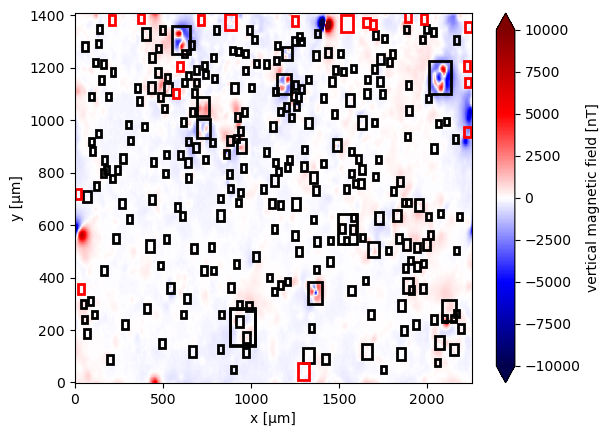

In [42]:
ax = plt.subplot(111)
data_up_copy_2.bz.plot.pcolormesh(ax=ax, cmap="seismic", vmin=-10000, vmax=10000)
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)   
for window in non_overlapping_windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="r",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)

# Show the observed and predicted data

In [43]:
predicted_data = mg.dipole_bz([coordinates[0], coordinates[1], data_up.z], positions_itr_enhanced, estimated_dipole_moments_itr_euler_enhanced)
residuo = data.bz.values - predicted_data

data_up = data_up.assign(predicted_data=(['y','x'],predicted_data))
data_up.predicted_data.attrs = {"long_name": "predicted-data", "units": "nT"}

error = data_up.bz.values - data_up.predicted_data.values

data_up = data_up.assign(error=(['y','x'],error))
data_up.error.attrs = {"long_name": "residual-data", "units": "nT"}

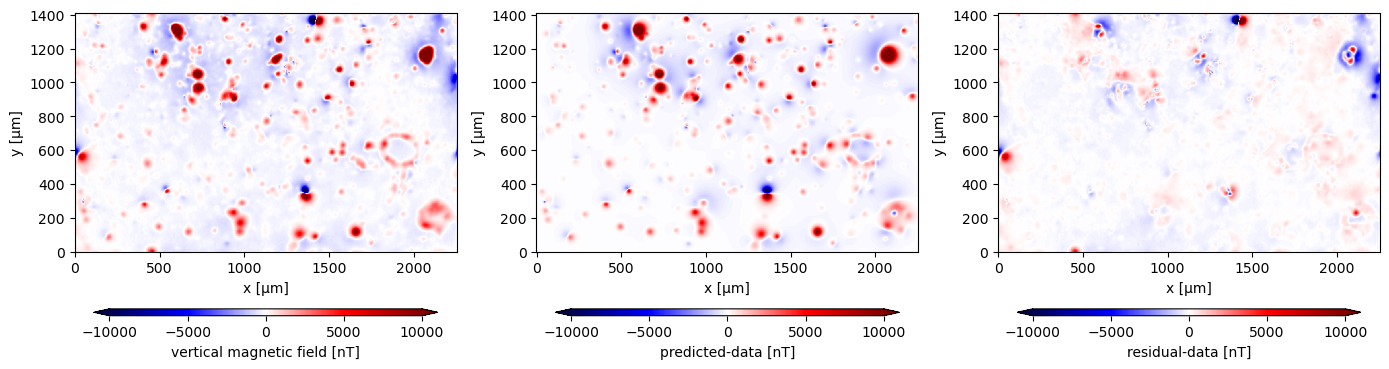

In [44]:
fig, axes = plt.subplots(1, 3, figsize=(14, 6))
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.1, shrink=0.9)
for field, ax in zip(["bz", "predicted_data", "error"], axes.ravel()):
    vmax = +10000
    vmin = -10000
    data_up[field].plot.pcolormesh(ax=ax, cmap="seismic", cbar_kwargs=cbar_kwargs, vmax=vmax, vmin=vmin)
for ax in axes.ravel():
    ax.set_aspect("equal")
plt.tight_layout()

1
Individual source:   R2 = 0.9294098564299695


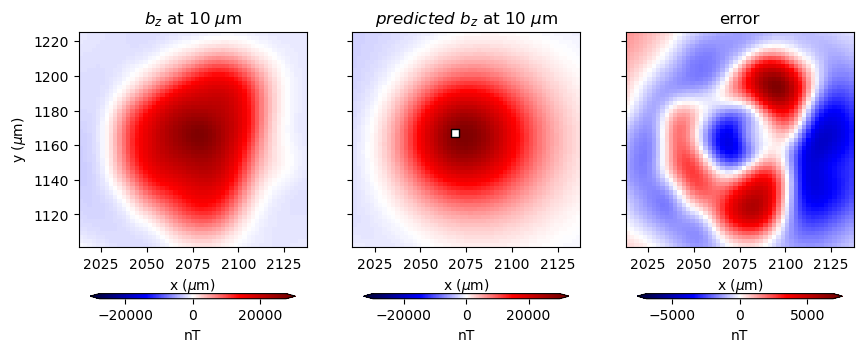

2
Individual source:   R2 = 0.9525373889863473


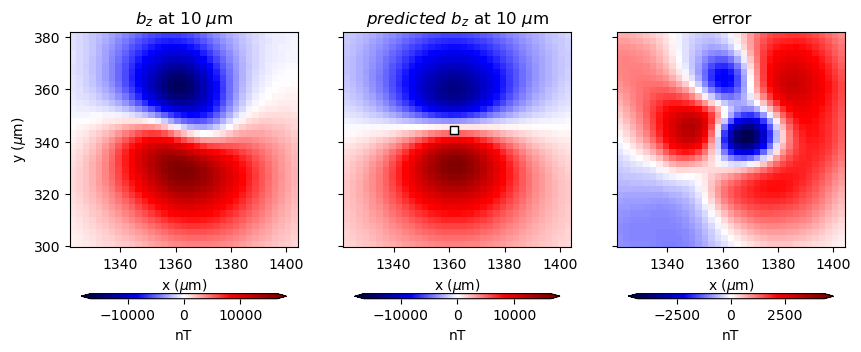

3
Individual source:   R2 = 0.983804668365692


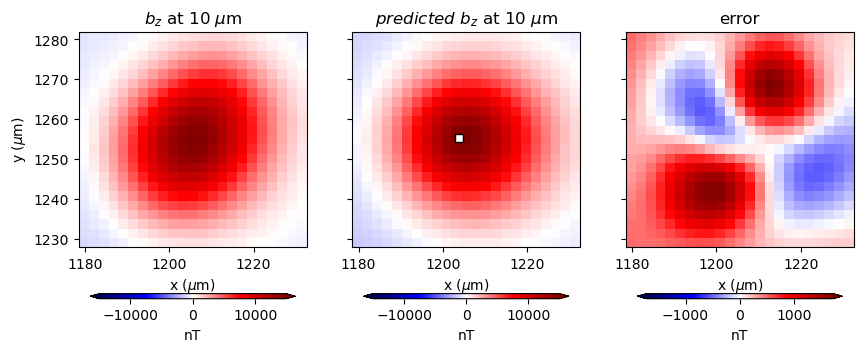

4
Individual source:   R2 = 0.8953907808545317


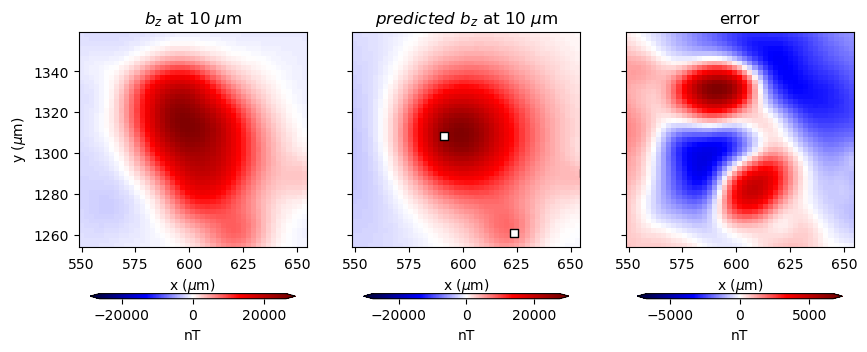

5
Individual source:   R2 = 0.9934869285959506


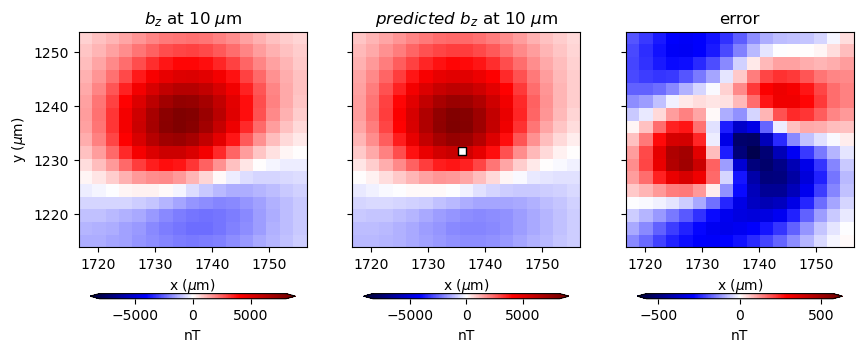

In [45]:
i = 0
slice_start=0#-20
slice_end=5#-1
for window, r2, base_level in zip(windows_enhanced[slice_start:slice_end], 
                                  calculated_r2_itr_euler_enhanced[slice_start:slice_end], 
                                  base_levels_itr_euler_enhanced[slice_start:slice_end]):

    if r2>=-np.inf:
        i=i+1
        print(i)
        # local_data = data_up.sel(x=slice(*window[:2]), y=slice(*window[2:]))
        local_data = data_up.copy(deep=True)
        local_data = local_data.sel(x=slice(*window[:2]), y=slice(*window[2:]))
        
        fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharey="row")
        axes = axes.ravel()    
        cbar_kwargs = dict(orientation="horizontal", aspect=40, pad=0.15, shrink=0.9)
        
        ax = axes[0]
        ax.set_aspect("auto")
        ax.set_title(f"$b_z$ at {data.z.values[0,0] + height_difference:.0f} $\mu$m")
        ax.set_xlabel("x ($\mu$m)")
        ax.set_ylabel("y ($\mu$m)")
        local_data.bz.values +- base_level
        tmp = local_data.bz.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False)#, vmax=vmax, vmin=vmin)
        fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
        # ax.scatter(dipole_coordinates[0], dipole_coordinates[1], color='w', marker='o', edgecolors='k')
        
        ax = axes[1]
        ax.set_aspect("auto")
        ax.set_title(f"$predicted~b_z$ at {data.z.values[0,0] + height_difference:.0f} $\mu$m")
        ax.set_xlabel("x ($\mu$m)")
        local_data.predicted_data.values += base_level
        tmp = local_data.predicted_data.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False)#, vmax=vmax, vmin=vmin)
        fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
        ax.scatter(positions_itr_enhanced[0], positions_itr_enhanced[1], color='w', marker='s', edgecolors='k')
        
        ax = axes[2]   
        ax.set_aspect("auto")
        ax.set_title("error")
        ax.set_xlabel("x ($\mu$m)")
        
        local_data.error.values = local_data.bz.values - local_data.predicted_data.values
        tmp = local_data.error.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False)
        fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
        
    
        print(r"Individual source:   R2 = %s"%(r2))
    
        plt.show()

In [46]:
# Nome do arquivo ZIP
output_folder = "csv_files_real_data"
os.makedirs(output_folder, exist_ok=True)

In [47]:
# Criar um DataFrame com os vetores
standard_dataframe = pd.DataFrame({
    'xmin': np.asarray(windows)[:, 0],
    'xmax': np.asarray(windows)[:, 1],
    'ymin': np.asarray(windows)[:, 2],
    'ymax': np.asarray(windows)[:, 3],
    'xc_standard': np.asarray(positions)[0, :],
    'yc_standard': np.asarray(positions)[1, :],
    'zc_standard': np.asarray(positions)[2, :],
    'mx_standard': np.asarray(estimated_dipole_moments)[:,0],
    'my_standard': np.asarray(estimated_dipole_moments)[:,1],
    'mz_standard': np.asarray(estimated_dipole_moments)[:,2],
    'r_2_standard': np.asarray(calculated_r2),
})
standard_csv_name = os.path.join(output_folder, nc_file.replace('.mat', '_standard.csv'))
standard_dataframe.to_csv(standard_csv_name, index=False)

# Criar DataFrame para os vetores iterativos
iterative_dataframe = pd.DataFrame({
    'xmin': np.asarray(windows_enhanced)[:, 0],
    'xmax': np.asarray(windows_enhanced)[:, 1],
    'ymin': np.asarray(windows_enhanced)[:, 2],
    'ymax': np.asarray(windows_enhanced)[:, 3],
    'xc_iterative': np.asarray(positions_itr_enhanced)[0, :],
    'yc_iterative': np.asarray(positions_itr_enhanced)[1, :],
    'zc_iterative': np.asarray(positions_itr_enhanced)[2, :],
    'mx_iterative': np.asarray(estimated_dipole_moments_itr_euler_enhanced)[:,0],
    'my_iterative': np.asarray(estimated_dipole_moments_itr_euler_enhanced)[:,1],
    'mz_iterative': np.asarray(estimated_dipole_moments_itr_euler_enhanced)[:,2],
    'r_2_iterative': np.asarray(calculated_r2_itr_euler_enhanced),
})

# # Salvar DataFrame iterativo como CSV
iterative_csv_name = os.path.join(output_folder, nc_file.replace('.mat', '_iterative.csv'))
iterative_dataframe.to_csv(iterative_csv_name, index=False)